In [1]:
# https://udemy.com/recommender-systems
# https://deeplearningcourses.com/recommender-systems
from __future__ import print_function, division
from builtins import range


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD

# config
batch_size = 128
epochs = 20
reg = 0.0001
# reg = 0

# esses arquivos são gerados pelo notebook "Preprocessing sparse matrix"
A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

Using TensorFlow backend.
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\d

N: 138493 M: 26744
N // batch_size: 1081
mu: 3.5254311349663534


In [2]:
# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

In [3]:
def custom_loss(y_true, y_pred):
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
  diff = y_pred - y_true
  sqdiff = diff * diff * mask
  sse = K.sum(K.sum(sqdiff))
  n = K.sum(K.sum(mask))
  return sse / n

In [4]:
def generator(A, M):
  while True:
    A, M = shuffle(A, M)
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      a = a - mu * m # must keep zeros at zero!
      # m2 = (np.random.random(a.shape) > 0.5)
      # noisy = a * m2
      noisy = a # no noise
      yield noisy, a

In [5]:
def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      a = a - mu * m
      at = at - mu * mt
      yield a, at

In [6]:
model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)

In [7]:
r = model.fit_generator(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)


Epoch 1/20
1082/1082 [==============================] - 239s 221ms/step - loss: 0.9881 - custom_loss: 0.7485 - val_loss: 0.8661 - val_custom_loss: 0.7065
Epoch 2/20
1082/1082 [==============================] - 242s 224ms/step - loss: 0.8321 - custom_loss: 0.6467 - val_loss: 0.8028 - val_custom_loss: 0.6864
Epoch 3/20
1082/1082 [==============================] - 262s 242ms/step - loss: 0.7687 - custom_loss: 0.6213 - val_loss: 0.7604 - val_custom_loss: 0.6755
Epoch 4/20
1082/1082 [==============================] - 242s 223ms/step - loss: 0.7284 - custom_loss: 0.6074 - val_loss: 0.7298 - val_custom_loss: 0.6709
Epoch 5/20
1082/1082 [==============================] - 248s 229ms/step - loss: 0.7006 - custom_loss: 0.5978 - val_loss: 0.7111 - val_custom_loss: 0.6674
Epoch 6/20
1082/1082 [==============================] - 260s 241ms/step - loss: 0.6816 - custom_loss: 0.5914 - val_loss: 0.7013 - val_custom_loss: 0.6639
Epoch 7/20
1082/1082 [==============================] - 289s 267ms/step - l

In [8]:
print(r.history.keys())

dict_keys(['val_loss', 'val_custom_loss', 'loss', 'custom_loss'])


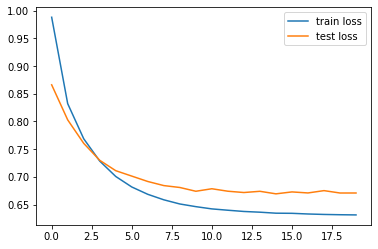

In [9]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

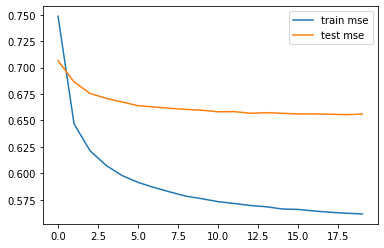

In [11]:
# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()